In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2D, Dropout,Flatten, BatchNormalization
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.optimizers import SGD
from statistics import *
import numpy as np

# The encoding process
input_img = Input(shape=(28, 28, 1))  


# Conv1 #
#convolution layer and relu layer
x = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', padding='same')(input_img)
#pooling layer
x = MaxPooling2D(pool_size = (2, 2), padding='same')(x)

# Conv2 #
#convolution layer and relu layer
x = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(x)
#pooling layer
x = MaxPooling2D(pool_size = (2, 2), padding='same')(x) 

# Conv 3 #
#convolution layer and relu layer
x = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(x)
#pooling layer
encoded = MaxPooling2D(pool_size = (2, 2), padding='same')(x)


Using TensorFlow backend.


In [2]:
# DeConv1
#convolution layer and relu layer
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
#The UpSampling2D Layer does the exact opposite of MaxPooling2D
x = UpSampling2D((2, 2))(x)

# DeConv2
#convolution layer and relu layer
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
#The UpSampling2D Layer does the exact opposite of MaxPooling2D
x = UpSampling2D((2, 2))(x)

# Deconv3
#convolution layer and relu layer
x = Conv2D(16, (3, 3), activation='relu')(x)
#The UpSampling2D Layer does the exact opposite of MaxPooling2D
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [3]:
# Declare the model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [4]:
# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # reshape dataset to have a single channel
    #the pixel values are grayscale, the pixel dimension is set to 1.
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

In [5]:
trainX, trainY, testX, testY = load_dataset()
input_shape = (28, 28, 1)

In [6]:
# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    # Making sure that the values are float so that we can get decimal points after division
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    # Normalizing the grey scale codes by dividing it by the max grey scale value.
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

In [7]:
trainX, testX = prep_pixels(trainX, testX)

In [8]:
#adding random noise to the data
def generate_noise_data(noise_factor):
    x_train_noisy = trainX+ noise_factor * np.random.normal(loc=0.0, scale=1.0, size=trainX.shape)
    x_test_noisy = testX + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=testX.shape)
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)
    return x_train_noisy, x_test_noisy

In [9]:
noise_factor = 0.50
x_train_noisy_new, x_test_noisy_new = generate_noise_data(noise_factor)

In [10]:
# Train the model
autoencoder.fit(x_train_noisy_new, trainX,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy_new, testX)
               )

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 98s 2ms/step - loss: 0.2578 - val_loss: 0.2070
Epoch 2/10
60000/60000 [==============================] - 101s 2ms/step - loss: 0.1889 - val_loss: 0.1765
Epoch 3/10
60000/60000 [==============================] - 104s 2ms/step - loss: 0.1706 - val_loss: 0.1667
Epoch 4/10
60000/60000 [==============================] - 106s 2ms/step - loss: 0.1599 - val_loss: 0.1602
Epoch 5/10
60000/60000 [==============================] - 121s 2ms/step - loss: 0.1541 - val_loss: 0.1501
Epoch 6/10
60000/60000 [==============================] - 119s 2ms/step - loss: 0.1500 - val_loss: 0.1469
Epoch 7/10
60000/60000 [==============================] - 126s 2ms/step - loss: 0.1470 - val_loss: 0.1480
Epoch 8/10
60000/60000 [==============================] - 101s 2ms/step - loss: 0.1446 - val_loss: 0.1393
Epoch 9/10
60000/60000 [==============================] - 103s 2ms/step - loss: 0.1430 - val_loss: 0.13

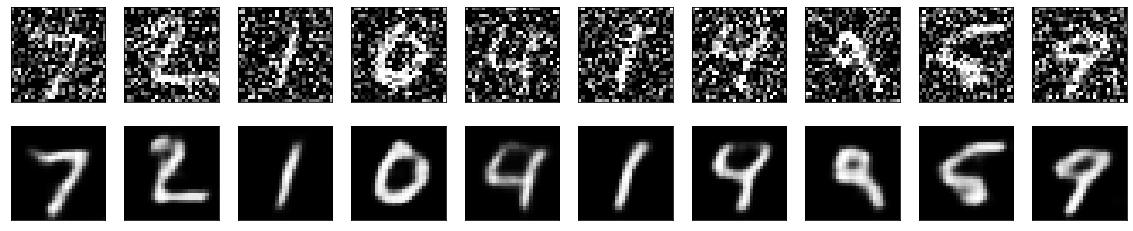

In [11]:
import matplotlib.pyplot as plt
decoded_imgs = autoencoder.predict(x_test_noisy_new)

n = 10

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy_new[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [12]:
decoded_imgs.shape

(10000, 28, 28, 1)

New model is trained using noise reduced decoded images for the classification and it's accuarcies can be seen as follows after each epoch

In [13]:
# deep learning models are created where an instance of the Sequential class is created
# model layers are created and added to it.
model = Sequential() 

# 28 filters, each being size of 3x3 and slides through the image  with a stride of magnitude 1 in horizontal and vertical direction using ReLU activation function
model.add(Conv2D(28, kernel_size=(3,3), strides=(1,1), input_shape=input_shape)) 

#adding batch normalization to changing the distribution by standarising the output
model.add(BatchNormalization())

#max pooling to extract digit features
model.add(MaxPooling2D(pool_size=(2,2)))

#increasing the model depth
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', strides=(1,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', strides=(1,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
#turns matrix values into a single vector
model.add(Flatten()) 
#hidden layer with 200 nodes and relu activation function
model.add(Dense(200,activation = "relu")) 
# dropout regularization to drop certain neurons to reduce overfitting
model.add(Dropout(0.3)) 
#adding batch normalization to changing the distribution by standarising the output
model.add(BatchNormalization())
#output layer for classification values of digits 0-9
model.add(Dense(10,activation = "softmax"))
# compile model
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(decoded_imgs, testY, epochs=10, validation_split=0.1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 15s 2ms/step - loss: 0.6362 - accuracy: 0.7977 - val_loss: 1.2007 - val_accuracy: 0.7260
Epoch 2/10
9000/9000 [==============================] - 15s 2ms/step - loss: 0.4039 - accuracy: 0.8731 - val_loss: 0.3886 - val_accuracy: 0.8740
Epoch 3/10
9000/9000 [==============================] - 15s 2ms/step - loss: 0.3472 - accuracy: 0.8882 - val_loss: 0.3372 - val_accuracy: 0.8940
Epoch 4/10
9000/9000 [==============================] - 15s 2ms/step - loss: 0.3080 - accuracy: 0.8944 - val_loss: 0.3823 - val_accuracy: 0.8820
Epoch 5/10
9000/9000 [==============================] - 15s 2ms/step - loss: 0.2826 - accuracy: 0.9091 - val_loss: 0.3282 - val_accuracy: 0.8980
Epoch 6/10
9000/9000 [==============================] - 15s 2ms/step - loss: 0.2437 - accuracy: 0.9187 - val_loss: 0.3121 - val_accuracy: 0.8920
Epoch 7/10
9000/9000 [==============================] - 15s 2ms/step - loss: 0.228